In [1]:
import distutils.util
import os

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

# from pyvirtualdisplay import Display 
# display = Display(visible = 0, size=(1400, 900))
# display.start()

import mujoco.viewer

A single inverted pendulum, converted from URDF:

In [ ]:
xml = """
<mujoco model="single_pendulum">
  <option gravity="0 0 -10"/>
  <option integrator="RK4"/>
  <option impratio="0"/>
  <compiler angle="radian"/>


  <worldbody>
    <light name="top" pos="-.5 0 1.5"/>

    <!-- tiny blue box -->
    <geom size="0.025 0.025 0.025" type="box" rgba="0 0 1 1"/>

    <!-- branch -->
    <body name="branch_link">
      <inertial pos="0 0 0.395" mass="0.05052" diaginertia="0.01051 0.01051 9.338e-07"/>
      <joint name="base_branch_joint" type="hinge" pos="0 0 0" axis="0 1 0"/>
      <geom size="0.00608 0.395" pos="0 0 0.395" type="cylinder" rgba="0 1 0 1"/>
    </body>

    <!-- branch 2-->
    <body name="branch_link_2">
      <inertial pos="0 0 0.395" mass="0.05052" diaginertia="0.01051 0.01051 9.338e-07"/>
      <joint name="branch_joint_2" type="hinge" pos="0 0 .395" axis="0 1 0"/>
      <geom size="0.00608 0.395" pos="0 0 0.395" type="cylinder" rgba="1 0 0 1"/>
    </body>

  </worldbody>

  <actuator>
    <torque name="base_torque" joint="base_branch_joint"/>
  </actuator>
  <actuator>
    <torque name="second_torque" joint="branch_joint_2"/>
  </actuator>

  <keyframe>
    <key name="initial" qpos=".1 -.1" qvel=".1 -.1" />
  </keyframe>
</mujoco>
"""

In [ ]:
xml = """
<mujoco model="single_pendulum">
  <option gravity="0 0 -10"/>
  <option integrator="RK4"/>
  <compiler angle="radian"/>

  <worldbody>
    <light name="top" pos="-.5 0 1.5"/>

    <!-- tiny blue box -->
    <geom size="0.025 0.025 0.025" type="box" rgba="0 0 1 1"/>

    <!-- branch -->
    <body name="branch_link">
      <inertial pos="0 0 0.395" mass="0.05052" diaginertia="0.01051 0.01051 9.338e-07"/>
      <joint name="base_branch_joint" type="hinge" pos="0 0 0" axis="0 1 0"/>
      <geom size="0.00608 0.395" pos="0 0 0.395" type="cylinder" rgba="0 1 0 1"/>
    </body>
  </worldbody>

  <!-- Define actuators -->
  <actuator>
    <motor joint="base_branch_joint" name="base_torque"/>
  </actuator>

  <keyframe>
    <key name="initial" qpos=".1" qvel="-.1" />
  </keyframe>
</mujoco>
"""

In [121]:
def pd_control(model, data, Kp, Kd, init_angles):
    """
    PD controller to simulate spring-damper at each joint in the system

    model: the MuJoCo model object
    data: the MuJoCo data object
    Kp: Proportional gains (array of length [# of joints])
    Kd: Derivative (damping) gains (array of length [# of joints])
    init_angles: initial resting positions for each joint. For a completely vertical branch, zero-array of length [# of joints]
    """
    for i in range(model.njnt):
        # Joint position & velocity
        qpos = data.qpos[i]
        qvel = data.qvel[i]

        #Calculate errors
        pos_error = init_angles[i]-qpos 
        vel_error = -qvel 

        #PD control 
        ctrl_tau = Kp[i]*pos_error + Kd[i]*vel_error 
        print(ctrl_tau)
        data.ctrl[i] = ctrl_tau


In [122]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# model.opt.timestep = .0001

duration = 3.8
framerate = 60

Kp = np.array([295])
Kd = np.array([.01])
init_angles = np.zeros(model.njnt)

timevals = []
posvals = []

frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    pd_control(model, data, Kp, Kd, init_angles)
    mujoco.mj_step(model, data)
    timevals.append(data.time)
    posvals.append(data.qpos.copy())
    if len(frames) < data.time*framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)
  

ValueError: XML Error: invalid keyword: 'ImplicitEuler'
Element 'option', line 4


Text(0.5, 0, 'Time (seconds)')

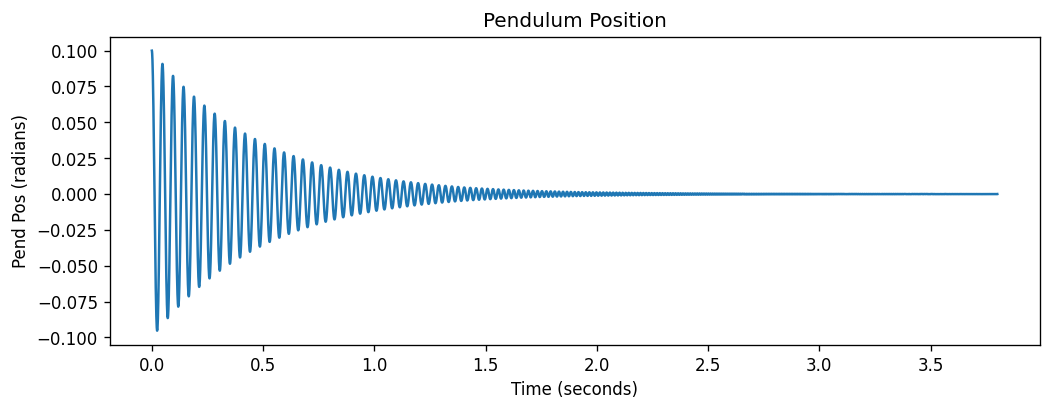

In [ ]:
dpi = 120
width = 1200
height = 400
figsize = (width/dpi, height/dpi)
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
ax.plot(timevals, posvals)

ax.set_title("Pendulum Position")
ax.set_ylabel("Pend Pos (radians)")
ax.set_xlabel("Time (seconds)")

In [ ]:
print(model.opt.timestep )

0.0001
